<a href="https://colab.research.google.com/github/Jandresol/neuro140_2/blob/main/assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download files

In [ ]:
!wget https://dataverse.harvard.edu/api/access/datafile/5347218
!wget https://dataverse.harvard.edu/api/access/datafile/5793795

In [ ]:
!unzip -o /content/5347218 -d /content/


# Configuration

In [180]:

#Config.py


# TRAINING SETTINGS
NUM_EPOCHS = 5


# LEARNING RATE SETTINGS
BASE_LR = 0.001
DECAY_WEIGHT = 0.1 # factor by which the learning rate is reduced.
EPOCH_DECAY = 30 # number of epochs after which the learning rate is decayed exponentially by DECAY_WEIGHT.


# DATASET INFO
NUM_CLASSES = 18 # set the number of classes in your dataset
DATA_DIR = '/content/biased_cars_1' # to run with the sample dataset, just set to 'hymenoptera_data'


# DATALOADER PROPERTIES
BATCH_SIZE = 64


# GPU SETTINGS
CUDA_DEVICE = 0 # Enter device ID of your gpu if you want to run on gpu. Otherwise neglect.
GPU_MODE = 0 # set to 1 if want to run on gpu.


# SETTINGS FOR DISPLAYING ON TENSORBOARD
USE_TENSORBOARD = 0 #if you want to use tensorboard set this to 1.
TENSORBOARD_SERVER = "YOUR TENSORBOARD SERVER ADDRESS HERE" # If you set.
EXP_NAME = "fine_tuning_experiment" # if using tensorboard, enter name of experiment you want it to be displayed as.

In [176]:
import torchvision
from torch.utils.data import Dataset
from PIL import Image
import os
import pickle

def is_valid_image_file(filename):
  # Check file name extension
  valid_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff']
  if os.path.splitext(filename)[1].lower() not in valid_extensions:
    print(f"Invalid image file extension \"{filename}\". Skipping this file...")
  # Verify that image file is intact
  try:
    with Image.open(filename) as img:
      img.verify()  # Verify if it's an image
      return True
  except (IOError, SyntaxError) as e:
    print(f"Invalid image file {filename}: {e}")
    return False


entries = os.listdir(DATA_DIR)
subdirectories = [entry for entry in entries if entry != ".ipynb_checkpoints" and os.path.isdir(os.path.join(DATA_DIR, entry))]
pickle_file_path = '/content/5793795'
print(subdirectories)
with open(pickle_file_path, 'rb') as file:
    data = pickle.load(file)




['GREEN_CARS', 'GREEN_CARS_9_SCALE_0_ROTATION', 'GREEN_CARS_9_SCALE_1_ROTATION', 'GREEN_CARS_9_SCALE_2_ROTATION', 'REBUTTAL_BLACK_CARS_9_SCALE_0_ROTATION', 'BLUE_CARS_9_SCALE_4_ROTATION', 'GREEN_CARS_9_SCALE_3_ROTATION', 'REBUTTAL_BLACK_CARS_9_SCALE_0_ROTATION_OLD', 'BLUE_CARS_9_SCALE_3_ROTATION', 'GREEN_CARS_9_SCALE_4_ROTATION']


# Define Dataset Class

In [177]:
class CarDataset(Dataset):
    def __init__(self, img_dir, split, data, transform=None, target_transform=None, shuffle=True):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.class_dict = {i: i for i in range(18)}
        self.split = split

        image_label_dict = {}
        self.class_counts = {class_label: 0 for class_label in self.class_dict.keys()}
        self.items = []
        self.total_items_loaded = len(self.items)
        self.class_labels = list(self.class_counts.keys())
        self.class_counts_list = list(self.class_counts.values())

        subdirectories = [subdir for subdir in os.listdir(img_dir) if os.path.isdir(os.path.join(img_dir, subdir))]

        for subdir in subdirectories:
            dir_path = os.path.join(img_dir, subdir, split, 'images')
            if os.path.exists(dir_path):
                for filename in os.listdir(dir_path):
                    file_path = os.path.join(dir_path, filename)
                    if os.path.isfile(file_path) and is_valid_image_file(file_path):
                        if filename in data and len(data[filename]) >= 4:
                            img_class = int(data[filename][3])
                            if img_class in self.class_dict:
                                image_label_dict[filename] = img_class
                                self.items.append((file_path, img_class))
                                self.class_counts[img_class] += 1
            #                     print(f"Added image: {file_path}, Class: {img_class}")
            #             else:
            #                 print(f"No valid information for image: {file_path}")
            #         else:
            #             print(f"Invalid image file: {file_path}")
            # print(f"Initialized {split} dataset with {len(self.items)} items.")


    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        file_path, label = self.items[idx]
        image = Image.open(file_path)

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        if self.target_transform:
            label = self.target_transform(label)

        return image, label


# Plot Images

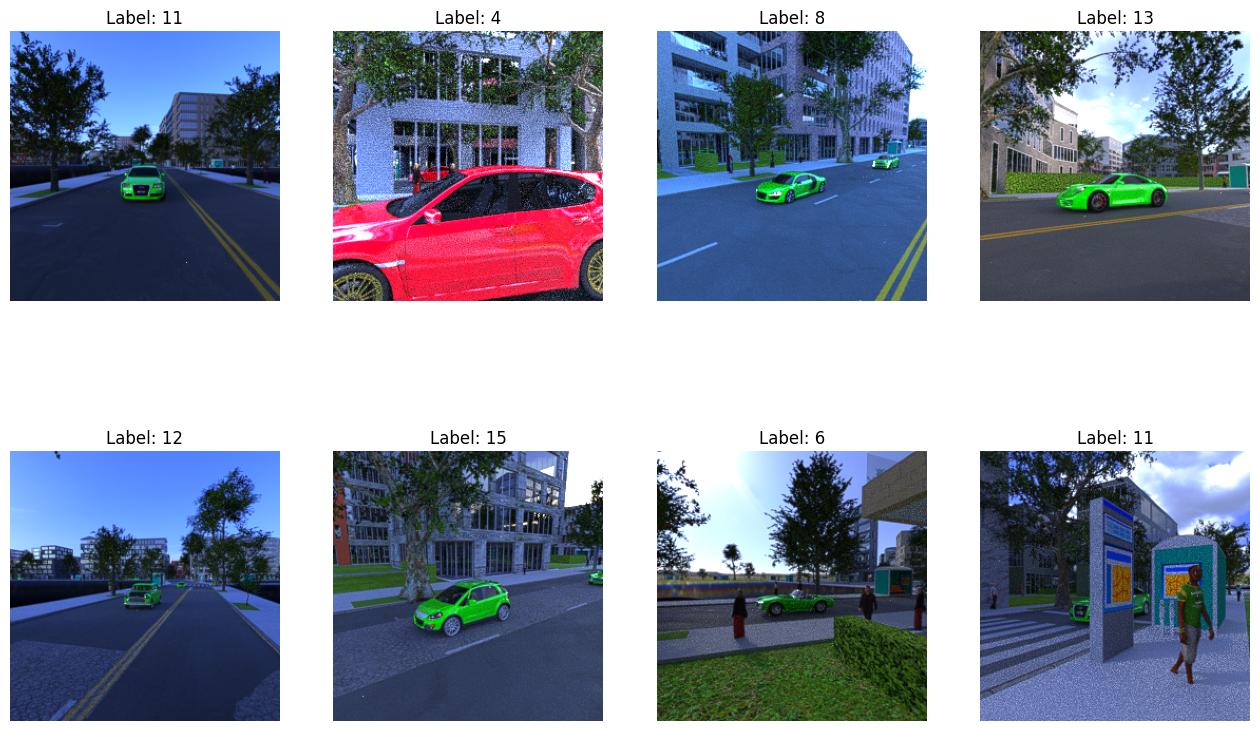

In [189]:
import pickle
import numpy as np
import matplotlib.pyplot as plt


car_dataset = CarDataset(
    img_dir=DATA_DIR,
    split = 'train',
    data=data,
    transform=None,
    target_transform=None
)

sample_indices = np.random.choice(len(car_dataset), size=8, replace=False)

# Plot the sample images
plt.figure(figsize=(16, 10))
for i, idx in enumerate(sample_indices):
    image, label = car_dataset[idx]

    plt.subplot(2, 4, i + 1)
    plt.imshow(image)
    plt.title(f'Label: {label}')
    plt.axis('off')

plt.show()


# Transforms and Data Loaders

In [181]:
### SECTION 1 - Imports and pytorch setup

from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, models, transforms
import time
import copy
import os
from PIL import ImageFile
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

ImageFile.LOAD_TRUNCATED_IMAGES = True


## If you want to use the GPU, set GPU_MODE TO 1 in config file
use_gpu = GPU_MODE
if use_gpu:
    torch.cuda.set_device(CUDA_DEVICE)


### SECTION 2 - data loading and shuffling/augmentation/normalization : all handled by torch automatically.

# Before being fed into the network during training, each image is transformed by undergoing augmentation and normalization.
#
# Data augmentation is a strategy to reduce overfitting. Instead of just feeding the same images into the network epoch after epoch
# until the network memorizes them, we feed a slightly perturbed version each time so it never sees exactly the same image more than once.
# For example (under data_transforms below):
# 1. RandomSizedCrop takes a crop of an image at various scales between 0.08 to 0.8 times the size of the image, and then resizes it to 224x224
# 2. RandomHorizontalFlip flips the image horizontally 50% of the time. For example, an image of a horse facing to the left would now be facing to the right.
#
# ToTensor() converts each image from a PIL.Image into a torch.Tensor so it can be fed into pytorch models
#
# Normalize(means, standard_deviations) normalizes each channel (e.g., red green blue a.k.a. RGB) by the dataset's overall mean and standard deviation
# for each of these three values. This allows the the network to receive input with consistent statistics, improving the mathematical stability of the
# network as it trains. In practice, it takes a long time to compute the exact mean and standard deviation of an entire dataset, so the values below
# (which are the means and stdevs from a large, popular dataset called ImageNet) are used as defaults, and good enough in most cases.
# The mean and standard deviation of photographs isn't going to change too much - but it might be important to recalculate these if you were working
# with a very different type of images (e.g., x-ray images).
#
# During validation (as opposed to training), we perform normalization but not augmentation - we want to test the network's performance on natural,
# unperturbed images. Resize() and CenterCrop() just deterministically ensure that we end up with a 224x224 image.

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

##################
# ADDED: custom torch Datasets for train and val
##################
dsets = {}
for split in ['train', 'val']:
    dsets[split] = CarDataset(DATA_DIR, split, data, data_transforms[split])




##################
# ImageFolder version of Dataset setup

# ImageFolder is a built-in pytorch class that produces a Dataset instance without you having to define your own Dataset class.
# It only works if data is formatted in a specific way.

# You need to organize your data such that your dataset folder has EXACTLY two folders. Name these 'train' and 'val' (always lower-case)
# The 'train' folder contains training set and 'val' fodler contains validation set on which accuracy is measured.

# The structure within 'train' and 'val' folders will be the same. They both contain one folder per class. All the images of that class
# are inside the folder named by class name.

# So basically, if your dataset has 3 classes and you're trying to classify between pictures of 1) dogs 2) cats and 3) humans,
# say you name your dataset folder 'data_dir'. Then inside 'data_dir' will be 'train' and 'val'. Further, Inside 'train' will be
# 3 folders - 'dogs', 'cats', 'humans'. All training images for dogs will be inside this 'dogs' folder.
# Similarly, within 'val' as well there will be the same 3 folders.

## So, the structure looks like this :
# data_dir
#      |- train
#            |- dogs
#                 |- dog_image_1
#                 |- dog_image_2
#                        .....
#            |- cats
#                 |- cat_image_1
#                 |- cat_image_1
#                        .....
#            |- humans
#      |- val
#            |- dogs
#            |- cats
#            |- humans
##################
# dsets = {}
# for split in ['train', 'val']:
#    dsets[split] = datxasets.ImageFolder(os.path.join(DATA_DIR, split), data_transforms[split])

total_class_counts = {}

dset_sizes = {split: len(dsets[split]) for split in ['train', 'val']}
print(dset_sizes)
# Define the dataloaders, using our dataset instances for train and val
dset_loaders = {}
for split in ['train', 'val']:
    dset_loaders[split] = torch.utils.data.DataLoader(dsets[split], batch_size=BATCH_SIZE, shuffle=True, num_workers=8)


# Define the dataloaders, using our dataset instances for train and val


for key, dataset in dsets.items():
    dataset_size = len(dataset)

    if dataset_size > 0:
        dset_loaders[key] = DataLoader(
            dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8
        )

        # Access class counts
        class_counts = dataset.class_counts
        for class_label, count in class_counts.items():
            total_class_counts[class_label] = total_class_counts.get(class_label, 0) + count




{'train': 6779, 'val': 1959}


# Statistics Plot

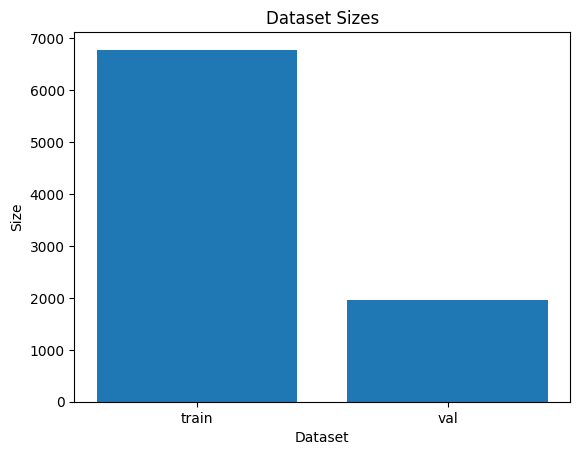

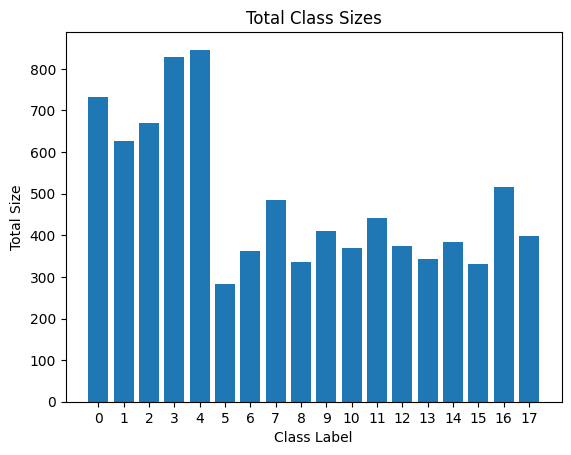

<Figure size 640x480 with 0 Axes>

In [182]:
# Plot dataset size for data and validation
dset_sizes = [len(dataset) for dataset in dsets.values()]
plt.bar(list(dsets.keys()), dset_sizes)
plt.xlabel('Dataset')
plt.ylabel('Size')
plt.title('Dataset Sizes')
plt.xticks(list(dsets.keys()))
plt.show()

# Plot total class size
total_class_sizes = list(total_class_counts.values())
class_labels = list(total_class_counts.keys())
plt.bar(class_labels, total_class_sizes)
plt.xlabel('Class Label')
plt.ylabel('Total Size')
plt.title('Total Class Sizes')
plt.xticks(range(18))

plt.show()

fig = plt.figure()



# Training

In [ ]:
###  3 - Writing the functions that do training and validation phase.

# The code below does forward propogation, back propogation, loss calculation, update weights of model, and save the best model at the end!

# As a brief outline:
#
# For the number of specified epochs (in config.py), train_model goes through a training and a validation phase.
# Hence the nested for loop: an outer loop for multiple epochs, and an inner loop to iterate through batches of data from the dataloader.
#
# In both training and validation phases, the loaded data is forward propogated through the model.
# In PyTorch, the Dataloader is an iterator that wraps around a Dataset class. There's a __getitem__ function which gets called every
# time the program iterates over the Dataloader - it fetches two tensors, inputs (the images) and labels (which are integers).
#
# Forward prop is as simple as calling model() as a function and passing in the input.
#
# The "Variable" class is like a wrappers on top of PyTorch Tensors that keeps track of every mathematical operation that tensor goes through.
# The benefit of this is that you don't need to write the equations for backpropogation, because the history of computations has been tracked
# and pytorch can automSECTIONatically differentiate it! Thus, 2 things are SUPER important. ALWAYS check for these 2 things.
# 1) NEVER overwrite a pytorch variable, as all previous history will be lost and automatic differentation ("autograd") won't work.
# 2) Variables can only undergo operations that are differentiable.

def train_model(model, criterion, optimizer, lr_scheduler, num_epochs=100):
    since = time.time()

    best_model = model
    best_acc = 0.0

    accuracies = {'train': [], 'val': []}
    losses = {'train': [], 'val': []}
    for epoch in range(num_epochs):
        print('-' * 10)
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                optimizer = lr_scheduler(optimizer, epoch)
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to eval mode for validation (no need to track gradients)

            running_loss = 0.0
            running_corrects = 0

            counter=0
            # Iterate over data, getting one batch of inputs (images) and labels each time.
            for data in dset_loaders[phase]:
                inputs, labels = data

                if use_gpu:
                    try:
                        inputs, labels = Variable(inputs.float().cuda()), Variable(labels.long().cuda())
                    except Exception as e:
                        print("ERROR! here are the inputs and labels before we print the full stack trace:")
                        print(inputs, labels)
                        raise e
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # Set gradient to zero to delete history of computations in previous epoch. Track operations so that differentiation can be done automatically.
                optimizer.zero_grad()
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)

                loss = criterion(outputs, labels)

                # Print a line every 10 batches so you have something to watch and don't feel like the program isn't running.
                if counter%10==0:
                    print("Reached batch iteration", counter)

                counter+=1

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                try:
                    running_loss += loss.item()
                    running_corrects += torch.sum(preds == labels.data)
                except:
                    print('unexpected error, could not calculate loss or do a sum.')

            epoch_loss = running_loss / dset_sizes[phase]
            epoch_acc = running_corrects.item() / float(dset_sizes[phase])
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            accuracies[phase].append(epoch_acc)
            losses[phase].append(epoch_loss)

            # deep copy the model
            if phase == 'val':
                if USE_TENSORBOARD:
                    foo.add_scalar_value('epoch_loss', epoch_loss,step=epoch)
                    foo.add_scalar_value('epoch_acc', epoch_acc,step=epoch)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model = copy.deepcopy(model)
                    print('new best accuracy =', best_acc)
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('returning and looping back')

    return best_model, accuracies, losses


# This function changes the learning rate as the model trains.
# If the learning rate is too high, training tends to be unstable and it's harder to converge on an optimal set of weights.
# But, if learning rate is too low, learning is too slow and you won't converge in a reasonable time frame. A good compromise
# is to start out with a high learning rate and then reduce it over time.
def exp_lr_scheduler(optimizer, epoch, init_lr=BASE_LR, lr_decay_epoch=EPOCH_DECAY):
    """Decay learning rate by a factor of DECAY_WEIGHT every lr_decay_epoch epochs."""
    lr = init_lr * (DECAY_WEIGHT**(epoch // lr_decay_epoch))

    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return optimizer


### SECTION 4 - DEFINING MODEL ARCHITECTURE.

##################
# MODIFIED: Added
# Set the number of classes in the config file by setting the right value for NUM_CLASSES.
##################
# model_ft = SimpleCNN(num_classes=NUM_CLASSES)

##################
# MODIFIED: Deleted
# We use Resnet18 here. If you have more computational power, feel free to swap it with Resnet50, Resnet100 or Resnet152.
# For fine tuning or transfer learning, we will use the pretrained net weights.
##################
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, NUM_CLASSES)


criterion = nn.CrossEntropyLoss()

if use_gpu:
    criterion.cuda()
    model_ft.cuda()

optimizer_ft = optim.RMSprop(model_ft.parameters(), lr=0.0001)


# Run the functions and save the best model in the function model_ft.
model_ft, accuracies, losses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=NUM_EPOCHS)

for split in ['train', 'val']:
    print(split, "accuracies by epoch:", accuracies[split])
    print(split, "losses by epoch:", losses[split])

# Save model
torch.save(model_ft.state_dict(), 'fine_tuned_best_model.pt')

----------
Epoch 0/4
----------
LR is set to 0.001
Reached batch iteration 0


# Accuracy and Loss Plots
### Not working due to runtime errors

Notes: I was unable to run the full training without my runtime timing out because google colab capped my GPU usage. Running one epoch yields: `train Loss: 0.2390 Acc: 0.9405`

Consequently, I cannot plot the losses or accuracies

NameError: name 'accuracies' is not defined

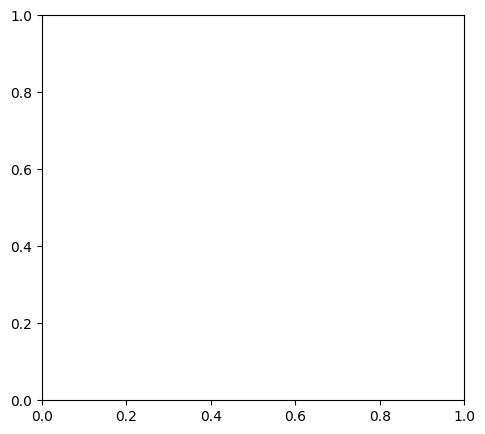

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracies
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(accuracies['train'], label='Train Accuracy')
plt.plot(accuracies['val'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracies Over Epochs')
plt.legend()

# Plot losses
plt.subplot(1, 2, 2)
plt.plot(losses['train'], label='Train Loss')
plt.plot(losses['val'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Losses Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


# Questions

Question 1. Examine your accuracy and loss plots.

(a) Do the overall trends you observe for loss and accuracy make sense? (i.e., should they be increasing or decreasing?)  [0.25 points]

Training and validation loss should decrease, training and validation accuracy should increase.

(b) What would you expect to happen if you trained the model for a huge number of epochs? (e.g., 1 million epochs). Specifically, what do you think would happen to the training loss, the validation loss, the training accuracy, and the validation accuracy? (hint: tutorial 2)  [0.25 points]

Training loss would continue to decrease until it plateaus, while validation loss would begin to increase. Training accuracy would increase until it plateaus, and validation accuracy would begin to decrease

Question 2. When evaluating a model’s performance, it is important to keep in mind what the model’s accuracy would be “at chance,” i.e. if it learned nothing during training.

(a) Let’s say the model truly learns nothing, and guesses one of the 18 classes completely at random for each image. What would you expect its accuracy to be on the validation set?  [0.25 points]

1/18, or 5.56% chance.

(b) Now let’s say the model learns only a trivial piece of information about the dataset: which class is the most common. What would the model’s accuracy be on the validation set if it always guessed the class that is most common in the training set?  [0.25 points]

It would be proportional to the samples that the most common data class has. If the most common dataset has 30% occurance, the accuracy will be 30%.
